In [1]:
import json
with open('evidence.json','r') as evd:
    evd_json = json.load(evd)
# Eg of an file
## evd_json['evidence-442946']
## 'At very high concentrations (100 times atmospheric concentration, or greater), carbon dioxide can be toxic to animal life, so raising the concentration to 10,000 ppm (1%) or higher for several hours will eliminate pests such as whiteflies and spider mites in a greenhouse.

with open('train-claims.json', 'r') as f:
    train_claims = json.load(f)

with open('dev-claims.json','r') as dev:
    dev_claims = json.load(dev) # 154 observations

with open('test-claims-unlabelled.json') as t:
    tst_claims = json.load(t) #154 observations

Extract raw text claims and evd 

In [2]:

train_claims_text = {k: v['claim_text'] for k, v in train_claims.items()}
train_claims_evd = {k : v['evidences'] for k, v in train_claims.items()}

# #  train_claims_text
# {'claim-1937': 'Not only is there no scientific evidence that CO2 is a pollutant, higher CO2 concentrations actually help ecosystems support more plant and animal life.',
#  'claim-126': 'El Niño drove record highs in global temperatures suggesting rise may not be down to man-made emissions.',
#  'claim-2510': 'In 1946, PDO switched to a cool phase.',

# train_claims_evd
## {'claim-1937': ['evidence-442946', 'evidence-1194317', 'evidence-12171'],
## 'claim-126': ['evidence-338219', 'evidence-1127398'],

dev_claims_text = {k: v['claim_text'] for k, v in dev_claims.items()}
dev_claims_evd = {k : v['evidences'] for k, v in dev_claims.items()}

tst_claims_text = {k: v['claim_text'] for k, v in tst_claims.items()}


Extract claims texts or evd. Output : dict( claim_text_id: claim_text (or evd))  
Perform text-preprocessing during the process  
Perform stemming as well?


In [3]:
def remove_special_chars(input_string):
    """
    Removes special characters from a string and returns the cleaned string
    """
    cleaned_string = ''
    for char in input_string:
        if char.isalnum() or char.isspace():
            cleaned_string += char
    return cleaned_string

def clean_text(arr):
    #Remove leading/trailing white spaces
    arr = arr.strip()

    #Remove special characters
    arr = remove_special_chars(arr)
    
    #Convert to lowercase
    arr = arr.lower()

    return arr

trn_claims_text = {k: clean_text(v['claim_text']) for k, v in train_claims.items()}
dev_claims_text = {k: clean_text(v['claim_text']) for k, v in dev_claims.items()}
tst_claims_text = {k: clean_text(v['claim_text']) for k, v in tst_claims.items()}

# trn_claims_text
## {'claim-1937': 'not only is there no scientific evidence that co2 is a pollutant higher co2 concentrations actually help ecosystems support more plant and animal life',
## 'claim-126': 'el niño drove record highs in global temperatures suggesting rise may not be down to manmade emissions',
 

Query single list of all text  
Query list of evd lists

In [4]:

#Create a list of all claims texts all lower-cased
trn_text = [[v] for v in trn_claims_text.values()]
dev_text = [[v] for v in dev_claims_text.values()]
tst_text = [[v] for v in tst_claims_text.values()]
evd = [k for k in evd_json]

# trn_text output
# [['not only is there no scientific evidence that co2 is a pollutant higher co2 concentrations actually help ecosystems support more plant and animal life'],
#  ['el niño drove record highs in global temperatures suggesting rise may not be down to manmade emissions'],
#  ['in 1946 pdo switched to a cool phase'],

trn_evd = [v for v in train_claims_evd.values()]
dev_evd = [v for v in dev_claims_evd.values()]
# trn_evd output:
#  [['evidence-442946', 'evidence-1194317', 'evidence-12171'],
#  ['evidence-338219', 'evidence-1127398'],

trn_label = [v["claim_label"] for v in train_claims.values()]
dev_label = [v["claim_label"] for v in dev_claims.values()]

# trn_label output:
# ['DISPUTED',
#  'REFUTES',
#  'SUPPORTS',

Create function that finds the evidence pieces matching the evidence ids in the sample sets 

In [5]:
def add_evd(sample_text, sample_evd): #data must be a list of evd pieces list
    big_list = []
    for i in range(len(sample_evd)):
        evd_list = []
        for evd_id in sample_evd[i]:
            evd_list.append(evd_json[evd_id])
        big_list.append(evd_list)
    
    text_evd = []
    for i in range(len(sample_text)):
        text_evd.append(sample_text[i] + big_list[i])

    text_evd = [' '.join(sublist) for sublist in text_evd]
    return text_evd




Concatenate each text_claim with the text of their corresponding evidence text then preprocess again

In [6]:
trn_text_evd = add_evd(trn_text, trn_evd)
dev_text_evd = add_evd(dev_text, dev_evd)

# trn_text_evd[0]
# 'not only is there no scientific evidence that co2 is a pollutant higher co2 concentrations actually help ecosystems support more plant and animal lifeAt very high concentrations (100 times atmospheric 

Perform the preprocessing step on concatenated texts

In [7]:
trn_text_evd = [clean_text(sublist) for sublist in trn_text_evd ]
dev_text_evd = [clean_text(sublist) for sublist in dev_text_evd]

# trn_text_evd[0]
# 'not only is there no scientific evidence that co2 is a pollutant higher co2 concentrations actually help ecosystems support more plant and animal life at very high c

Grab all unique evidences in training and development sets

In [10]:
trn_dev_unique_evd = list(set( [evd for sublist in trn_evd + dev_evd for evd in sublist]))

Function which removes stopwords and returns bag of words represention

In [22]:
from nltk.corpus import stopwords
def get_bow(data): #data is a list of lists
    bow = {}
    for label_list in data:
        for word in label_list:
            if word not in stopwords.words('english'): 
                bow[word] = bow.get(word,0) + 1
    return bow


In [23]:
trn_text_tokn = [word_tokenizer.tokenize(v) for v in trn_claims_text.values()]
dev_text_tokn = [word_tokenizer.tokenize(v) for v in dev_claims_text.values()]
tst_text_tokn = [word_tokenizer.tokenize(v) for v in tst_claims_text.values()]

Lemmatisation of text

In [24]:
word_tokenizer = nltk.tokenize.regexp.WordPunctTokenizer()

# Tokenize the claims in each inner list
trn_text_tokn = [word_tokenizer.tokenize(v) for v in trn_claims_text.values()]
dev_text_tokn = [word_tokenizer.tokenize(v) for v in dev_claims_text.values()]
tst_text_tokn = [word_tokenizer.tokenize(v) for v in tst_claims_text.values()]


unique_bow_trn = get_bow(trn_text_tokn)
unique_bow_dev = get_bow(dev_text_tokn)
unique_bow_tst = get_bow(tst_text_tokn)


unique_bow_trn = sorted(unique_bow_trn.items(), key=lambda x: x[1], reverse=True)
unique_bow_dev = sorted(unique_bow_dev.items(), key=lambda x: x[1], reverse=True)
unique_bow_tst = sorted(unique_bow_tst.items(), key=lambda x: x[1], reverse=True)
# unique_bow_dev

List of lists where each list contains words from a text claim after removing stopwords and preserving the order from the og json file

Histogram of top ten common words in trn set (no stopword removal)

In [25]:
# unique_bow_trn
# import matplotlib.pyplot as plt

# trn_words = [word for word, count in unique_bow_trn[:10]]
# trn_counts = [counts for word, counts in unique_bow_trn[:10]]

# fig = plt.figure(figsize=(12, 6), dpi=100)

# plt.bar(trn_words, trn_counts) # plot histogram
# plt.title('Top 10 most frequent words in training set')
# plt.xlabel('Words')
# fig.suptitle('Figure 2', size= 11 , y=0, ha = 'center', fontstyle = 'italic')
# plt.ylabel('Frequency')
# plt.show()

In [26]:

# Perform POS tagging
trn_tagged_words = nltk.pos_tag([word[0] for word in unique_bow_trn])
# [('warming', 'VBG'),
#  ('climate', 'NN'),

# Define the set of POS tags that we want to keep (nouns)
pos_tags = ['NN', 'NNS', 'NNP', 'NNPS' , 'RB'] #, 'JJ']
# 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBN', 'VBP', 'VBZ']

# Filter out words that are not nouns, adjectives, or verbs
trn_important_bow = [unique_bow_trn[i] for i in range(len(unique_bow_trn)) if trn_tagged_words[i][1] in pos_tags ]

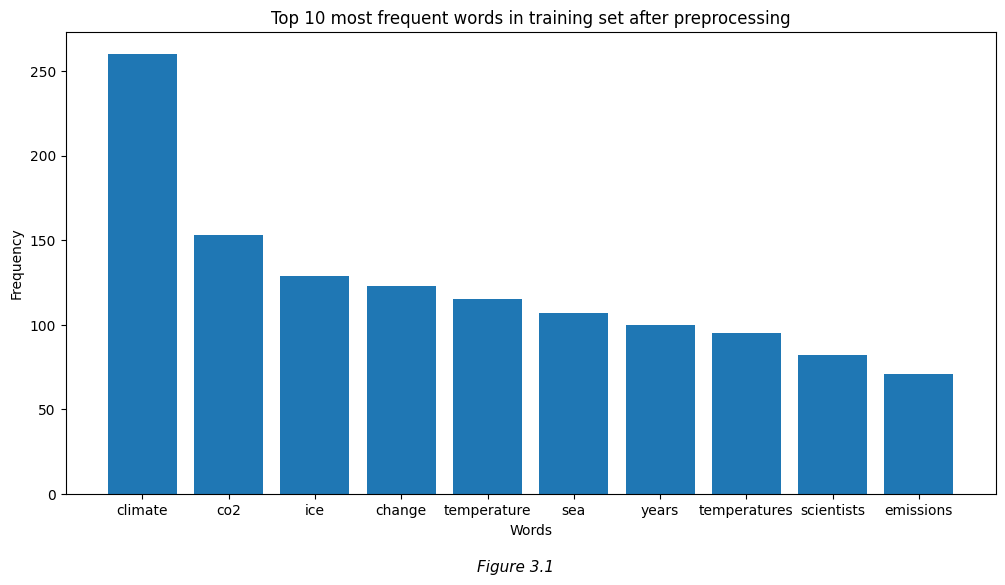

In [41]:
import matplotlib.pyplot as plt
trn_important = [word for word, count in trn_important_bow]
trn_important10_words = [word for word, count in trn_important_bow[:10]]
# ['warming',
#  'climate',
#  'global',
trn_important10_counts = [counts for word, counts in trn_important_bow[:10]]

fig = plt.figure(figsize=(12, 6), dpi=100)

plt.bar(trn_important10_words, trn_important10_counts) # plot histogram
plt.title('Top 10 most frequent words in training set after preprocessing')
plt.xlabel('Words')
fig.suptitle('Figure 3.1', size= 11 , y=0, ha = 'center', fontstyle = 'italic')
plt.ylabel('Frequency')
plt.show()

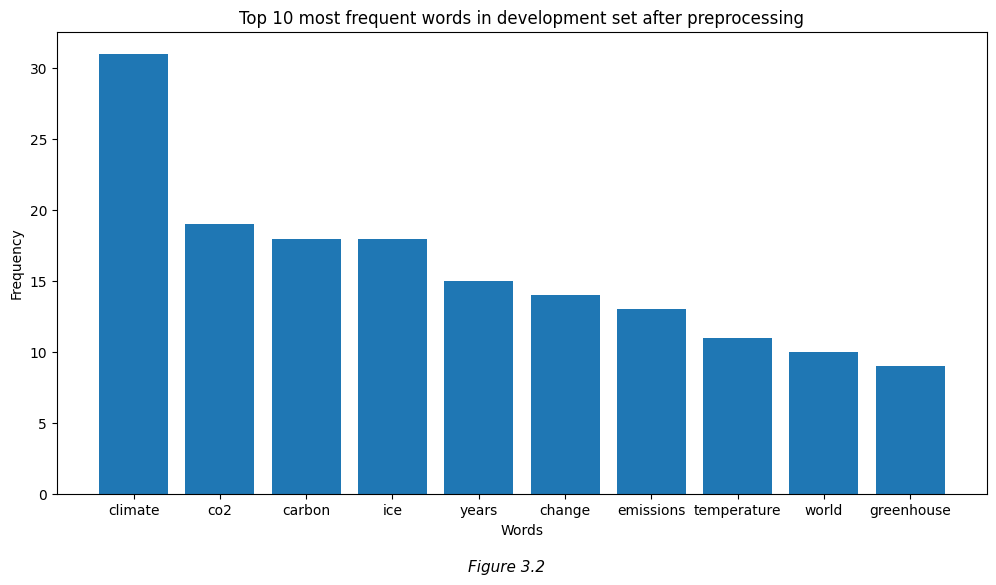

In [42]:
# Perform POS tagging
dev_tagged_words = nltk.pos_tag([word[0] for word in unique_bow_dev])

# Filter out words that are not nouns, adjectives, or verbs
dev_important_bow = [unique_bow_dev[i] for i in range(len(unique_bow_dev)) if dev_tagged_words[i][1] in pos_tags]

dev_important10_words = [word for word, count in dev_important_bow[:10]]
dev_important10_counts = [counts for word, counts in dev_important_bow[:10]]

fig = plt.figure(figsize=(12, 6), dpi=100)

plt.bar(dev_important10_words, dev_important10_counts) # plot histogram
plt.title('Top 10 most frequent words in development set after preprocessing')
plt.xlabel('Words')
fig.suptitle('Figure 3.2', size = 11, y=0, ha = 'center', fontstyle = 'italic')
plt.ylabel('Frequency')
plt.show()

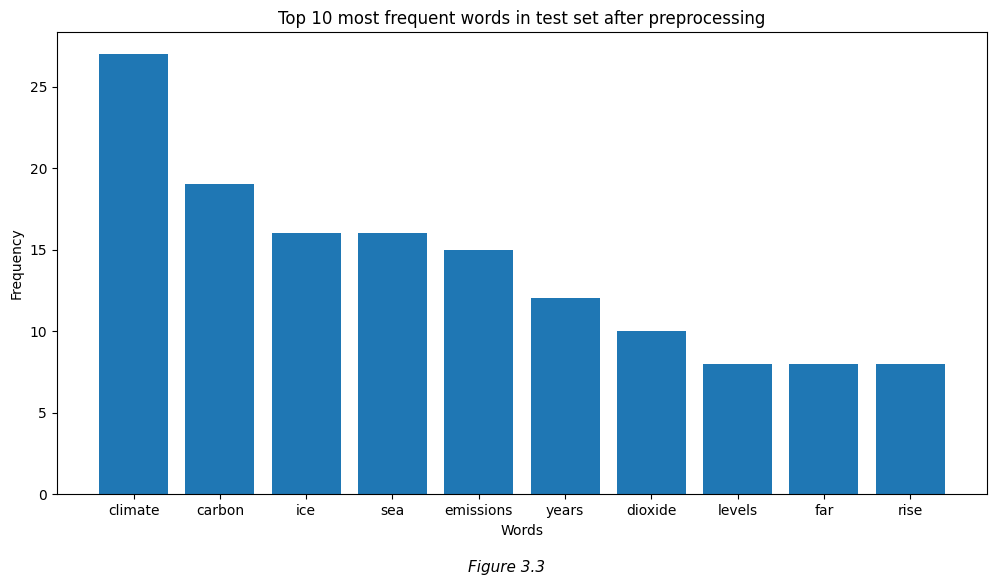

In [43]:
# Perform POS tagging
tst_tagged_words = nltk.pos_tag([word[0] for word in unique_bow_tst])

# Filter out words that are not nouns, adjectives, or verbs
tst_important_bow = [unique_bow_tst[i] for i in range(len(unique_bow_tst)) if tst_tagged_words[i][1] in pos_tags]

tst_important10_words = [word for word, count in tst_important_bow[:10]]
tst_important10_counts = [counts for word, counts in tst_important_bow[:10]]

fig = plt.figure(figsize=(12, 6), dpi=100)

plt.bar(tst_important10_words, tst_important10_counts) # plot histogram
plt.title('Top 10 most frequent words in test set after preprocessing')
plt.xlabel('Words')
fig.suptitle('Figure 3.3', size= 11, y=0, ha = 'center', fontstyle = 'italic')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Getting all unique non-function words in training + development sets - for cosine similarity 
unique_bow_trndev = get_bow(trn_text_tokn + dev_text_tokn)
unique_bow_trndev = sorted(unique_bow_trndev.items(), key= lambda x: x[1], reverse= True)
trndev_tagged_words = nltk.pos_tag([word[0] for word in unique_bow_trndev])
# Filter out words that are not nouns, adjectives, or verbs
trndev_important_bow = [unique_bow_trndev[i] for i in range(len(unique_bow_trndev)) if trndev_tagged_words[i][1] in pos_tags 
                        ]
trndev_important_words_cosine = [word[0] for word in trndev_important_bow]


Add function which removes the stopwords from list of lists of tokenised words for doc2vec

In [28]:
def stopword_removal_nested_list(list_of_lists):
    n = len(list_of_lists)
    remove_stopword = []
    for i in range(n):
        arr = []
        for word in list_of_lists[i]:
            if word not in stopwords.words('english'):
                arr.append(word)
        remove_stopword.append(arr)
    return remove_stopword

In [29]:
trn_text_evd_tokn_stopword = stopword_removal_nested_list(trn_text_evd_tokn)    
dev_text_evd_tokn_stopword = stopword_removal_nested_list(dev_text_evd_tokn)    

Get all evidences required for model training

In [30]:
# tst_text_tokn = [word_tokenizer.tokenize(v) for v in tst_text]
trn_text_evd_tokn_sentence = [' '.join(sentence) for sentence in trn_text_evd_tokn]
dev_text_evd_tokn_sentence = [' '.join(sentence) for sentence in dev_text_evd_tokn]


SVC: Finding the relevant evidences

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time
from nltk.corpus import stopwords
stopword = stopwords.words('english')


#Create bag of words matrix removing stopwords
vectorizer = CountVectorizer(stop_words= stopword)
X_train = vectorizer.fit_transform(trn_text_evd_tokn_sentence)
X_dev = vectorizer.transform(dev_text_evd_tokn_sentence)

# create multi-label binarizer that returns all possible evidences 
mlb = MultiLabelBinarizer(classes = model_trn_evd)
y_train = mlb.fit_transform(trn_evd)
y_dev = mlb.transform(dev_evd)

#Choose LogisticRegression classifier and fit to training data - why
clf = OneVsRestClassifier(LinearSVC())
clf.fit(X_train, y_train)



y_pred = clf.predict(X_dev)

# Convert binary predictions back to label format using inverse_transform
# y_pred = mlb.inverse_transform(y_pred)

print('Accuracy:', accuracy_score(y_dev, y_pred))
print('Precision:', precision_score(y_dev, y_pred, average='micro'))
print('Recall:', recall_score(y_dev, y_pred, average='micro'))
print('F1 Score:', f1_score(y_dev, y_pred, average='micro'))


c:\Users\Yi Qian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
c:\Users\Yi Qian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
c:\Users\Yi Qian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 22 is present in all training examples.
  warnings.warn(
c:\Users\Yi Qian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 28 is present in all training examples.
  warnings.warn(
c:\Users\Yi Qian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 76 is present in all training examples.
  warnings.warn(
c:\Users\Yi Qian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\multiclass.py

Accuracy: 0.0
Precision: 0.00205761316872428
Recall: 0.002036659877800407
F1 Score: 0.0020470829068577278


In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time
from nltk.corpus import stopwords
stopword = stopwords.words('english')

trn_text_tokn_sentence = [' '.join(sentence) for sentence in trn_text_tokn]
dev_text_tokn_sentence = [' '.join(sentence) for sentence in dev_text_tokn]
#Create bag of words matrix removing stopwords
vectorizer = CountVectorizer(stop_words= stopword)
X_train = vectorizer.fit_transform(trn_text)
X_dev = vectorizer.transform(dev_text)


# create multi-label binarizer that returns all possible evidences 
le = LabelEncoder()#classes = ['SUPPORTS', 'DISPUTED', 'REFUTES', 'NOT_ENOUGH_INFO'])
y_train = le.fit_transform(trn_label)
y_dev = le.transform(dev_label)

#Choose LogisticRegression classifier and fit to training data - why
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_label_prob = clf.predict_proba(X_dev)

# Make probability predictions on the development data
y_pred_label = y_pred_label_prob.argmax(axis=1)

# Convert the integer labels to class names
class_names = le.classes_
y_pred_label_class_names = [class_names[label] for label in y_pred_label]


print('Accuracy:', accuracy_score(y_dev, y_pred_label))


Accuracy: 0.4090909090909091
Precision: 0.4090909090909091
Recall: 0.4090909090909091
F1 Score: 0.4090909090909091


Doc2Vec

In [139]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
n = 500
documents = [TaggedDocument(doc, [str(i)]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=n, window= 5, min_count=1, workers=4, dm = 1, epochs = 50)

In [140]:
import numpy as np
def doc2vec(text_tokn): #list of tokenised sublist
    trn_doc_vectors = []
    for i in range(len(text_tokn)):
        vec_doc = np.zeros(n)
        vec_doc = model.infer_vector(text_tokn[i])
        trn_doc_vectors.append(vec_doc)
    trn_doc_vectors = np.array(trn_doc_vectors)
    return trn_doc_vectors

In [ ]:
trn_text_evd1 = [[trn_text_evd[i]] for i in range(len(trn_text_evd))]

In [130]:
trn_text_evd_doc2vec_1032= doc2vec(trn_text_evd1)
trn_text_doc2vec_1032= doc2vec(trn_text)
dev_text_doc2vec_1032 = doc2vec(dev_text)
tst_text_doc2vec_1032 = doc2vec(tst_text)